In [19]:
# ========================================
# CELL 0: Install/Upgrade Required Packages
# ========================================

!pip install --upgrade bitsandbytes transformers==4.56.0 tokenizers==0.22.0


In [20]:
# ========================================
# CELL 1: Install and Import Dependencies
# ========================================
!pip install -q transformers torch datasets peft accelerate
!pip install -q umap-learn hdbscan scikit-learn pandas numpy matplotlib seaborn
!pip install -q biopython tqdm evaluate

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [21]:
# ========================================
# CELL 1B: Upload Files and Convert BLAST to FASTA
# ========================================
import os
import subprocess
import sqlite3
import pandas as pd
from Bio import SeqIO
import re
from google.colab import files

# Install dependencies if needed
try:
    from Bio import SeqIO
except ImportError:
    !pip install biopython

try:
    subprocess.run(["blastdbcmd", "-version"], capture_output=True, check=True)
except (subprocess.CalledProcessError, FileNotFoundError):
    print("Installing NCBI BLAST+...")
    !apt-get update
    !apt-get install -y ncbi-blast+

print("📁 Please upload your BLAST database files:")
print("Required files:")
print("- All 18S_fungal_sequences.* files (ndb, nhr, nin, nsq, etc.)")
print("- taxdb.btd")
print("- taxdb.bti")
print("- taxonomy4blast.sqlite3")
print()

# Upload files
uploaded = files.upload()
print(f"✅ Uploaded files: {list(uploaded.keys())}")

# List all files to verify
print("\n📋 Files in current directory:")
for file in os.listdir("."):
    if os.path.isfile(file):
        size = os.path.getsize(file) / 1024  # KB
        print(f"  {file} ({size:.1f} KB)")

# Convert BLAST Database to FASTA
def convert_blast_to_fasta(db_name="18S_fungal_sequences", output_file="18S_sequences.fasta"):
    """Convert BLAST database to FASTA format"""

    print(f"\n🔄 Converting {db_name} to FASTA format...")

    # Check if required database files exist
    required_extensions = ['.ndb', '.nhr', '.nin', '.nsq']
    required_files = [f"{db_name}{ext}" for ext in required_extensions]

    print("Checking for required database files:")
    missing_files = []
    for file in required_files:
        if os.path.exists(file):
            print(f"  ✅ {file}")
        else:
            print(f"  ❌ {file} (missing)")
            missing_files.append(file)

    if missing_files:
        print(f"\n❌ Missing files: {missing_files}")
        print("Please upload all the 18S_fungal_sequences.* files")
        return False

    try:
        # Run blastdbcmd to convert to FASTA
        print(f"\n⚙️ Running blastdbcmd...")

        result = subprocess.run([
            "blastdbcmd",
            "-db", db_name,
            "-entry", "all",
            "-outfmt", "%f",  # FASTA format
            "-out", output_file
        ], capture_output=True, text=True, check=True)

        print(f"✅ Conversion successful!")

        # Check output
        if os.path.exists(output_file):
            file_size = os.path.getsize(output_file) / (1024*1024)  # MB
            print(f"✅ Created {output_file} ({file_size:.2f} MB)")

            # Quick count of sequences
            with open(output_file, 'r') as f:
                seq_count = sum(1 for line in f if line.startswith('>'))
            print(f"✅ Contains {seq_count:,} sequences")

            # Show sample sequences
            print(f"\n📝 Sample sequences:")
            count = 0
            with open(output_file, 'r') as f:
                for line in f:
                    if line.startswith('>') and count < 3:
                        print(f"  {line.strip()}")
                        count += 1
                    elif count >= 3:
                        break

            return True
        else:
            print("❌ Output file not created")
            return False

    except subprocess.CalledProcessError as e:
        print(f"❌ blastdbcmd failed!")
        print(f"Error: {e}")
        print(f"STDERR: {e.stderr}")
        return False
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return False

# Run conversion
print("\n" + "="*60)
print("🚀 STARTING BLAST DATABASE CONVERSION")
print("="*60)

conversion_success = convert_blast_to_fasta()

if conversion_success:
    print("\n" + "="*60)
    print("✅ BLAST CONVERSION SUCCESSFUL!")
    print("="*60)
    print("📁 Output file: 18S_sequences.fasta")
    print("🎯 Ready to proceed with data loading and analysis")
    print("="*60)
else:
    print("\n" + "="*60)
    print("❌ BLAST CONVERSION FAILED!")
    print("="*60)
    print("Please check that all required database files are uploaded correctly.")
    print("Required files: 18S_fungal_sequences.ndb, .nhr, .nin, .nsq")


📁 Please upload your BLAST database files:
Required files:
- All 18S_fungal_sequences.* files (ndb, nhr, nin, nsq, etc.)
- taxdb.btd
- taxdb.bti
- taxonomy4blast.sqlite3



Saving 18S_fungal_sequences.ndb to 18S_fungal_sequences (1).ndb
Saving 18S_fungal_sequences.nhr to 18S_fungal_sequences (1).nhr
Saving 18S_fungal_sequences.nin to 18S_fungal_sequences (1).nin
Saving 18S_fungal_sequences.nsq to 18S_fungal_sequences (1).nsq
Saving 18S_fungal_sequences.nto to 18S_fungal_sequences (1).nto
Saving taxdb.btd to taxdb (1).btd
Saving taxdb.bti to taxdb (1).bti
Saving taxonomy4blast.sqlite3 to taxonomy4blast (1).sqlite3
✅ Uploaded files: ['18S_fungal_sequences (1).ndb', '18S_fungal_sequences (1).nhr', '18S_fungal_sequences (1).nin', '18S_fungal_sequences (1).nsq', '18S_fungal_sequences (1).nto', 'taxdb (1).btd', 'taxdb (1).bti', 'taxonomy4blast (1).sqlite3']

📋 Files in current directory:
  taxdb.btd (167178.8 KB)
  18S_fungal_sequences.nto (29.8 KB)
  taxonomy4blast.sqlite3 (84248.0 KB)
  18S_fungal_sequences.nin (43.4 KB)
  taxdb.bti (17621.7 KB)
  18S_fungal_sequences (1).nin (43.4 KB)
  18S_sequences.fasta (5241.5 KB)
  18S_fungal_sequences.nsq (1207.2 KB)
 

In [22]:
# ========================================
# CELL 2A: Check Existing Files
# ========================================
import os
import numpy as np

# Check if required files exist
required_files = [
    "18S_sequences.fasta",
    "taxonomy4blast.sqlite3"
]

print("📁 Checking for required files...")
for file in required_files:
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024*1024)
        print(f"  ✅ {file} ({size_mb:.2f} MB)")
    else:
        print(f"  ❌ {file} (missing)")

# If files exist, proceed with Cell 2
if all(os.path.exists(f) for f in required_files):
    print("\n🚀 All files ready! Proceeding with data loading...")
else:
    print("\n⚠️  Missing files! You need to run the BLAST conversion steps first.")


📁 Checking for required files...
  ✅ 18S_sequences.fasta (5.12 MB)
  ✅ taxonomy4blast.sqlite3 (82.27 MB)

🚀 All files ready! Proceeding with data loading...


In [23]:
# ========================================
# CELL 2: Load and Validate FASTA Data
# ========================================
from Bio import SeqIO

def validate_sequences(sequences):
    """Validate and clean DNA sequences"""
    valid_seqs = []
    valid_indices = []

    for i, seq in enumerate(sequences):
        # Convert to uppercase and check for valid DNA characters
        seq_clean = seq.upper()
        if len(seq_clean) >= 100 and set(seq_clean).issubset({'A', 'T', 'G', 'C', 'N'}):
            valid_seqs.append(seq_clean)
            valid_indices.append(i)

    return valid_seqs, valid_indices

def load_fasta_with_validation(fasta_file="18S_sequences.fasta"):
    """Load and validate FASTA sequences"""
    print("Loading sequences from FASTA...")

    sequences = []
    seq_ids = []
    descriptions = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq))
        seq_ids.append(record.id)
        descriptions.append(record.description)

    print(f"✓ Loaded {len(sequences)} raw sequences")

    # Validate sequences
    valid_sequences, valid_indices = validate_sequences(sequences)

    # Filter all arrays to keep only valid sequences
    valid_seq_ids = [seq_ids[i] for i in valid_indices]
    valid_descriptions = [descriptions[i] for i in valid_indices]

    print(f"✓ {len(valid_sequences)} sequences passed validation")
    print(f"✓ Removed {len(sequences) - len(valid_sequences)} invalid sequences")

    return valid_sequences, valid_seq_ids, valid_descriptions

# Load and validate data
sequences, seq_ids, descriptions = load_fasta_with_validation()

# Display basic statistics
seq_lengths = [len(seq) for seq in sequences]
print(f"\nSequence Statistics:")
print(f"  Count: {len(sequences)}")
print(f"  Length - Mean: {np.mean(seq_lengths):.1f}, Std: {np.std(seq_lengths):.1f}")
print(f"  Length - Min: {min(seq_lengths)}, Max: {max(seq_lengths)}")


Loading sequences from FASTA...
✓ Loaded 3692 raw sequences
✓ 3568 sequences passed validation
✓ Removed 124 invalid sequences

Sequence Statistics:
  Count: 3568
  Length - Mean: 1330.3, Std: 368.8
  Length - Min: 414, Max: 2861


In [24]:
# ========================================
# CELL 3: Extract Hierarchical Taxonomic Labels
# ========================================

def extract_hierarchical_labels(seq_ids, descriptions):
    """Extract genus and species labels with validation"""
    taxonomic_labels = {}
    extraction_stats = {'successful': 0, 'failed': 0, 'genus_only': 0}

    for seq_id, desc in zip(seq_ids, descriptions):
        # Enhanced regex for scientific names
        scientific_pattern = r'\b([A-Z][a-z]+)\s+([a-z][a-z]+(?:\s+[a-z]+)?)\b'
        match = re.search(scientific_pattern, desc)

        if match:
            genus = match.group(1)
            species_part = match.group(2).strip()

            # Validate genus (should be reasonable length)
            if 3 <= len(genus) <= 20 and genus.isalpha():
                taxonomic_labels[seq_id] = {
                    'genus': genus,
                    'species': species_part,
                    'genus_species': f"{genus}_{species_part}",
                    'description': desc
                }
                extraction_stats['successful'] += 1
            else:
                extraction_stats['failed'] += 1
        else:
            # Try to extract genus only
            words = desc.split()
            potential_genus = None
            for word in words[1:4]:  # Check first few words after sequence ID
                if (word.isupper() and
                    len(word) > 3 and
                    word.isalpha() and
                    word not in ['Gene', 'RNA', 'TYPE', 'CBS', 'ATCC']):
                    potential_genus = word
                    break

            if potential_genus:
                taxonomic_labels[seq_id] = {
                    'genus': potential_genus,
                    'species': 'unknown',
                    'genus_species': f"{potential_genus}_unknown",
                    'description': desc
                }
                extraction_stats['genus_only'] += 1
            else:
                extraction_stats['failed'] += 1

    print(f"Label Extraction Results:")
    print(f"  ✓ Full genus+species: {extraction_stats['successful']}")
    print(f"  ✓ Genus only: {extraction_stats['genus_only']}")
    print(f"  ❌ Failed: {extraction_stats['failed']}")
    print(f"  📊 Total labeled: {len(taxonomic_labels)}")

    return taxonomic_labels

# Extract labels
taxonomic_labels = extract_hierarchical_labels(seq_ids, descriptions)

# Analyze label distribution
genera = [info['genus'] for info in taxonomic_labels.values()]
unique_genera = sorted(list(set(genera)))
genus_counts = pd.Series(genera).value_counts()

print(f"\n📊 Taxonomy Statistics:")
print(f"  Unique genera: {len(unique_genera)}")
print(f"  Coverage: {len(taxonomic_labels)/len(sequences)*100:.1f}%")
print(f"\nTop 10 most common genera:")
print(genus_counts.head(10))


Label Extraction Results:
  ✓ Full genus+species: 3495
  ✓ Genus only: 14
  ❌ Failed: 59
  📊 Total labeled: 3509

📊 Taxonomy Statistics:
  Unique genera: 1400
  Coverage: 98.3%

Top 10 most common genera:
Mucor              48
Candida            35
Alternaria         31
Ogataea            28
Scolecobasidium    26
Lophiostoma        24
Ophiocordyceps     22
Aspergillus        22
Exophiala          22
Suhomyces          21
Name: count, dtype: int64


In [25]:
# ========================================
# CELL 4 (FIXED): Prepare Dataset and Stratified Splits
# ========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def prepare_supervised_dataset(sequences, seq_ids, taxonomic_labels, min_samples_per_genus=5):
    """Filter genera by minimum count and encode labels."""
    # Collect all labeled items
    labeled_data = [
        {'sequence': sequences[i], 'seq_id': seq_ids[i],
         'genus': taxonomic_labels[seq_ids[i]]['genus']}
        for i in range(len(seq_ids)) if seq_ids[i] in taxonomic_labels
    ]
    print(f"✓ Found {len(labeled_data)} labeled sequences")

    # Count per genus
    genus_counts = Counter(item['genus'] for item in labeled_data)
    valid_genera = {g for g, c in genus_counts.items() if c >= min_samples_per_genus}

    # Filter out rare genera
    filtered = [item for item in labeled_data if item['genus'] in valid_genera]
    print(f"✓ After filtering (min {min_samples_per_genus} per genus): {len(filtered)} sequences")
    print(f"✓ Genera retained: {len(valid_genera)} (dropped {len(genus_counts)-len(valid_genera)})")

    # Extract sequences and labels
    seqs = [item['sequence'] for item in filtered]
    labels = [item['genus']    for item in filtered]

    # Encode genera to integer labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    print(f"✓ Dataset: {len(seqs)} sequences, {len(encoder.classes_)} genera")

    return seqs, y, encoder

# Prepare
ml_sequences, ml_labels, genus_encoder = prepare_supervised_dataset(
    sequences, seq_ids, taxonomic_labels, min_samples_per_genus=5
)

# 1) First split: train vs test (20% test)
train_seqs, test_seqs, train_lbls, test_lbls = train_test_split(
    ml_sequences, ml_labels,
    test_size=0.20,
    stratify=ml_labels,
    random_state=42
)

# 2) Second split: train vs validation (20% of *training*)
train_seqs, val_seqs, train_lbls,  val_lbls = train_test_split(
    train_seqs, train_lbls,
    test_size=0.20,            # 20% of the *training* → ~16% overall
    stratify=train_lbls,
    random_state=42
)

print(f"\nSplit sizes:")
print(f"  Train:      {len(train_seqs)}")
print(f"  Validation: {len(val_seqs)}")
print(f"  Test:       {len(test_seqs)}")
print(f"Classes (genera): {len(genus_encoder.classes_)}")


✓ Found 3509 labeled sequences
✓ After filtering (min 5 per genus): 1626 sequences
✓ Genera retained: 176 (dropped 1224)
✓ Dataset: 1626 sequences, 176 genera

Split sizes:
  Train:      1040
  Validation: 260
  Test:       326
Classes (genera): 176


In [36]:
# ========================================
# CELL 5 (UPDATED): Load Nucleotide Transformer (100M) for Classification
# ========================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, gc

MODEL_NAME = "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species"
NUM_LABELS = len(set(train_lbls))  # Adjust dynamically based on your dataset

# --- Clear GPU memory before loading new model ---
gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading Nucleotide Transformer model: {MODEL_NAME} on {device}")

# --- Load tokenizer and model for sequence classification ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    num_labels=NUM_LABELS,  # dynamic classification head
)

# --- Move model to GPU if available ---
model.to(device)
model.train()  # set to train mode for fine-tuning

print(f"✓ Model loaded with {NUM_LABELS} output labels")

# --- Tokenization test ---
print("\n🧪 Tokenization test:")
sample_seq = train_seqs[0][:200]  # take first 200 bases
tokens = tokenizer(
    sample_seq,
    truncation=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**tokens)
    print(f"Logits shape: {outputs.logits.shape}")


Loading Nucleotide Transformer model: InstaDeepAI/nucleotide-transformer-v2-100m-multi-species on cuda


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

✓ Model loaded with 176 output labels

🧪 Tokenization test:
Logits shape: torch.Size([1, 176])


In [37]:
# ========================================
# CELL 6 (UPDATED FOR NUCLEOTIDE TRANSFORMER V2 - 100M)
# ========================================
import re
import torch
from datasets import Dataset
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# --- Detect device and mixed precision ---
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    mixed_precision = "bf16"
    print("🚀 TPU detected, using bf16")
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mixed_precision = "fp16" if torch.cuda.is_available() else None
    print(f"🚀 Device detected: {device}, using {mixed_precision}")

# --- DNA Preprocessing ---
def preprocess_sequence(seq):
    """
    Preprocess nucleotide sequence:
    - Uppercase
    - Replace U with T
    - Replace invalid bases with N
    """
    seq = seq.upper().replace("U", "T")
    seq = re.sub(r"[^ACGTN]", "N", seq)
    return seq

def tokenize_sequences(sequences, tokenizer, max_length=512):
    """
    Tokenize raw DNA sequences for Nucleotide Transformer v2.
    Model expects raw nucleotides, not k-mers.
    """
    processed = [preprocess_sequence(seq) for seq in sequences]
    return tokenizer(
        processed,
        truncation=True,
        padding=False,  # Dynamic padding handled later
        max_length=max_length,
        return_tensors=None
    )

def create_dataset(sequences, labels, tokenizer):
    """Create Hugging Face dataset for nucleotide sequences."""
    assert len(sequences) == len(labels), "Sequences and labels must match length"
    print(f"Tokenizing {len(sequences)} nucleotide sequences...")
    encodings = tokenize_sequences(sequences, tokenizer)
    dataset = Dataset.from_dict({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": labels
    })
    return dataset

# --- Dataset Creation ---
print("Creating datasets (Nucleotide Transformer v2 - 100M)...")
train_dataset = create_dataset(train_seqs, train_lbls.tolist(), tokenizer)
val_dataset   = create_dataset(val_seqs,   val_lbls.tolist(),   tokenizer)
test_dataset  = create_dataset(test_seqs,  test_lbls.tolist(),  tokenizer)

print(f"✓ Train dataset: {len(train_dataset)} samples")
print(f"✓ Validation dataset: {len(val_dataset)} samples")
print(f"✓ Test dataset: {len(test_dataset)} samples")

# --- Metrics Function ---
def compute_metrics(eval_pred):
    """Compute accuracy, weighted and macro F1."""
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    _, _, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "accuracy": accuracy,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "precision": precision,
        "recall": recall
    }

# --- Data Collator (dynamic padding) ---
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# --- Training Arguments ---
training_args = TrainingArguments(
    output_dir="./nucleotide-transformer-v2-100m-taxonomy",
    num_train_epochs=5,
    per_device_train_batch_size=8 if mixed_precision != "fp16" else 4,  # safer for GPU
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1 if mixed_precision != "fp16" else 2,
    warmup_ratio=0.1,
    weight_decay=0.01,
    learning_rate=2e-4,
    fp16=(mixed_precision=="fp16"),
    bf16=(mixed_precision=="bf16"),
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    remove_unused_columns=False,
    dataloader_num_workers=2,
    seed=42
)

print("✓ Training configuration ready (Nucleotide Transformer v2 - 100M)")


🚀 Device detected: cuda, using fp16
Creating datasets (Nucleotide Transformer v2 - 100M)...
Tokenizing 1040 nucleotide sequences...
Tokenizing 260 nucleotide sequences...
Tokenizing 326 nucleotide sequences...
✓ Train dataset: 1040 samples
✓ Validation dataset: 260 samples
✓ Test dataset: 326 samples
✓ Training configuration ready (Nucleotide Transformer v2 - 100M)


In [40]:
# ========================================
# CELL 7: LoRA Fine-Tuning (GPU/TPU Safe) - 100M Model
# ========================================
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType

MODEL_NAME = "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species"

# --- Detect device and mixed precision ---
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    mixed_precision = "bf16"
    print("🚀 TPU detected, using bf16")
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mixed_precision = "fp16" if torch.cuda.is_available() else None
    print(f"🚀 Device detected: {device}, using {mixed_precision}")

# --- Create label list ---
label_list = sorted(list(set(train_dataset["labels"])))

# --- Load Model + Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    num_labels=len(label_list)
).to(device)

# --- LoRA Config (lighter for 100M model) ---
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"]
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# --- Data Collator (dynamic padding) ---
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# --- Training Arguments (fixed eval/save strategy) ---
training_args = TrainingArguments(
    output_dir="./nucleotide-transformer-v2-100m-lora",
    per_device_train_batch_size=8 if mixed_precision != "fp16" else 4,
    gradient_accumulation_steps=1 if mixed_precision != "fp16" else 2,
    eval_strategy="steps",   # match with save_strategy
    save_strategy="steps",         # FIXED (was "epoch")
    save_steps=100,                # how often to save
    eval_steps=100,                # how often to eval
    num_train_epochs=3,
    learning_rate=3e-4,
    fp16=(mixed_precision=="fp16"),
    bf16=(mixed_precision=="bf16"),
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False
)

# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("🔥 Starting LoRA fine-tuning (100M model)...")
training_result = trainer.train()
print(f"✅ Training complete! Final loss: {training_result.training_loss:.4f}")

# --- Save ---
save_dir = "./nucleotide-transformer-v2-100m-lora"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"💾 Model & tokenizer saved to {save_dir}")


🚀 Device detected: cuda, using fp16


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

trainable params: 713,392 || all params: 96,584,897 || trainable%: 0.7386
🔥 Starting LoRA fine-tuning (100M model)...


Step,Training Loss,Validation Loss
100,4.878100,4.762229
200,4.175100,4.375668
300,3.650400,4.180071


✅ Training complete! Final loss: 4.3202
💾 Model & tokenizer saved to ./nucleotide-transformer-v2-100m-lora


In [42]:
# ========================================
# CELL 8 (PATCHED): Evaluate LoRA Model
# ========================================

import numpy as np
from sklearn.metrics import classification_report

# --- Evaluate on test set ---
print("📊 Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print("🎯 Test Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        print(f"  {metric_name}: {value:.4f}")

# --- Predictions ---
print("\n📋 Generating detailed classification report...")
test_predictions = trainer.predict(test_dataset)
y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = test_predictions.label_ids

# --- Build genus names safely ---
try:
    genus_names = [id_to_genus[i] for i in range(len(id_to_genus))]
except NameError:
    try:
        genus_names = [str(lbl) for lbl in label_list]  # fallback to label_list
    except NameError:
        genus_names = [str(i) for i in range(len(set(y_true)))]  # numeric fallback

# --- Classification report ---
report = classification_report(
    y_true,
    y_pred,
    target_names=genus_names,
    output_dict=True,
    zero_division=0
)

# --- Show top performing genera ---
genus_f1_scores = [
    (genus, metrics['f1-score'])
    for genus, metrics in report.items()
    if genus not in ['accuracy', 'macro avg', 'weighted avg'] and metrics['support'] > 0
]
genus_f1_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop 20 genera by F1-score:")
for i, (genus, f1) in enumerate(genus_f1_scores[:20]):
    support = report[genus]['support']
    print(f"  {i+1:2d}. {genus:20s} F1: {f1:.3f} (n={support:3.0f})")

# --- Overall metrics ---
print(f"\n📈 Overall Performance:")
print(f"  Accuracy: {report['accuracy']:.4f}")
print(f"  Macro F1: {report['macro avg']['f1-score']:.4f}")
print(f"  Weighted F1: {report['weighted avg']['f1-score']:.4f}")


📊 Evaluating on test set...


🎯 Test Results:
  loss: 4.1910
  runtime: 3.8041
  samples_per_second: 85.6960
  steps_per_second: 10.7780

📋 Generating detailed classification report...

Top 20 genera by F1-score:
   1. 29                   F1: 1.000 (n=  1)
   2. 43                   F1: 1.000 (n=  1)
   3. 71                   F1: 1.000 (n=  1)
   4. 126                  F1: 1.000 (n=  1)
   5. 168                  F1: 0.857 (n=  3)
   6. 90                   F1: 0.727 (n=  4)
   7. 12                   F1: 0.667 (n=  2)
   8. 56                   F1: 0.667 (n=  2)
   9. 80                   F1: 0.667 (n=  2)
  10. 95                   F1: 0.667 (n=  2)
  11. 105                  F1: 0.667 (n=  2)
  12. 122                  F1: 0.667 (n=  2)
  13. 164                  F1: 0.667 (n=  2)
  14. 49                   F1: 0.500 (n=  3)
  15. 139                  F1: 0.500 (n=  3)
  16. 140                  F1: 0.500 (n=  3)
  17. 143                  F1: 0.500 (n=  2)
  18. 159                  F1: 0.500 (n=  2)
  19. 1

In [49]:
# ========================================
# CELL 9: Generate Embeddings for Clustering (FINAL PATCHED)
# ========================================

def get_embeddings_batch(sequences, model, tokenizer, batch_size=16, pooling="cls"):
    """
    Generate embeddings from the encoder of the fine-tuned model.
    pooling = "cls" or "mean"
    """
    model.eval()
    embeddings = []
    print(f"Generating embeddings for {len(sequences)} sequences...")

    # --- Access encoder backbone correctly ---
    try:
        encoder = model.backbone.model    # ✅ raw transformer (Nucleotide Transformer)
    except AttributeError:
        try:
            encoder = model.base_model    # fallback (e.g. DNABERT)
        except AttributeError:
            encoder = model               # last resort: assume model is already encoder

    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Embedding"):
            batch = sequences[i:i+batch_size]

            # Tokenize
            inputs = tokenizer(
                batch,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            # Forward pass through encoder backbone
            outputs = encoder(**inputs, output_hidden_states=True)

            # ✅ Safely extract hidden states
            if hasattr(outputs, "last_hidden_state"):
                hidden = outputs.last_hidden_state          # encoder output
            else:
                hidden = outputs.hidden_states[-1]          # classifier case

            # Pooling strategy
            if pooling == "cls":
                batch_embeddings = hidden[:, 0, :]
            elif pooling == "mean":
                mask = inputs["attention_mask"].unsqueeze(-1)
                summed = (hidden * mask).sum(1)
                counts = mask.sum(1)
                batch_embeddings = summed / counts
            else:
                raise ValueError("pooling must be 'cls' or 'mean'")

            embeddings.append(batch_embeddings.cpu())

            # Free memory
            del inputs, outputs, hidden
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return torch.cat(embeddings, dim=0)


# --- Generate embeddings ---
print("🧬 Generating embeddings with fine-tuned Nucleotide Transformer...")
all_embeddings = get_embeddings_batch(sequences, model, tokenizer, batch_size=8, pooling="mean")

print(f"✅ Generated embeddings: {all_embeddings.shape}")
print(f"   Sequences: {all_embeddings.shape[0]}")
print(f"   Embedding dimension: {all_embeddings.shape[1]}")

# Save
torch.save(all_embeddings, "nt_v2_embeddings.pt")
print("✅ Embeddings saved to 'nt_v2_embeddings.pt'")


🧬 Generating embeddings with fine-tuned Nucleotide Transformer...
Generating embeddings for 3568 sequences...


Embedding: 100%|██████████| 446/446 [01:22<00:00,  5.40it/s]

✅ Generated embeddings: torch.Size([3568, 512])
   Sequences: 3568
   Embedding dimension: 512
✅ Embeddings saved to 'nt_v2_embeddings.pt'


In [50]:
# ========================================
# CELL 10: UMAP Dimensionality Reduction (PATCHED)
# ========================================
import umap
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def apply_umap_reduction(embeddings, n_components_2d=2, n_components_cluster=20,
                         n_neighbors=30, min_dist_cluster=0.0, min_dist_viz=0.1, metric="cosine"):
    """
    Apply UMAP for both clustering and visualization.
    - embeddings: torch.Tensor or np.ndarray
    - n_components_2d: output dim for visualization
    - n_components_cluster: output dim for clustering
    """
    # Convert to numpy float32
    embeddings_np = embeddings.detach().cpu().numpy().astype(np.float32) if torch.is_tensor(embeddings) else embeddings.astype(np.float32)

    print(f"🗺️ Applying UMAP reduction...")
    print(f"   Input shape: {embeddings_np.shape}")

    # --- UMAP for clustering (higher dimensional) ---
    reducer_cluster = umap.UMAP(
        n_components=n_components_cluster,
        n_neighbors=n_neighbors,
        min_dist=min_dist_cluster,
        metric=metric,
        random_state=42,
        n_jobs=-1
    )
    print(f"   Computing {n_components_cluster}D embedding for clustering...")
    umap_cluster = reducer_cluster.fit_transform(embeddings_np)

    # --- UMAP for visualization (2D) ---
    reducer_viz = umap.UMAP(
        n_components=n_components_2d,
        n_neighbors=n_neighbors,
        min_dist=min_dist_viz,
        metric=metric,
        random_state=42,
        n_jobs=-1
    )
    print(f"   Computing {n_components_2d}D embedding for visualization...")
    umap_viz = reducer_viz.fit_transform(embeddings_np)

    return umap_cluster, umap_viz, reducer_cluster, reducer_viz


# --- Apply UMAP ---
umap_cluster, umap_viz, reducer_cluster, reducer_viz = apply_umap_reduction(
    all_embeddings,
    n_components_2d=2,
    n_components_cluster=20,
    n_neighbors=30,
    min_dist_cluster=0.0,
    min_dist_viz=0.1,
    metric="cosine"
)

print(f"✅ UMAP reduction completed:")
print(f"   Clustering embedding: {umap_cluster.shape}")
print(f"   Visualization embedding: {umap_viz.shape}")

# Save UMAP results
np.save("umap_cluster.npy", umap_cluster)
np.save("umap_viz.npy", umap_viz)
print("✅ UMAP results saved")


🗺️ Applying UMAP reduction...
   Input shape: (3568, 512)
   Computing 20D embedding for clustering...
   Computing 2D embedding for visualization...
✅ UMAP reduction completed:
   Clustering embedding: (3568, 20)
   Visualization embedding: (3568, 2)
✅ UMAP results saved


In [51]:
# ========================================
# CELL 11: HDBSCAN Clustering for Novel Taxa Discovery (PATCHED)
# ========================================
import hdbscan

def apply_hdbscan_clustering(umap_embeddings, min_cluster_size=20, min_samples=10,
                             metric="euclidean", cluster_selection_epsilon=0.05):
    """
    Apply HDBSCAN clustering for novel taxa discovery.

    Returns:
        cluster_labels: array of cluster IDs (-1 = noise)
        clusterer: fitted HDBSCAN object
        n_clusters: number of clusters found
        n_noise: number of noise points
        probabilities: membership probabilities
    """
    # Convert to numpy float32 if needed
    embeddings_np = (umap_embeddings.detach().cpu().numpy().astype(np.float32)
                     if torch.is_tensor(umap_embeddings)
                     else umap_embeddings.astype(np.float32))

    print(f"🔍 Applying HDBSCAN clustering...")
    print(f"   Input shape: {embeddings_np.shape}")
    print(f"   Min cluster size: {min_cluster_size}")
    print(f"   Min samples: {min_samples}")
    print(f"   Metric: {metric}")

    # --- HDBSCAN clustering ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        metric=metric,
        cluster_selection_method="eom",  # Excess of mass
        alpha=1.0
    )

    cluster_labels = clusterer.fit_predict(embeddings_np)
    probabilities = clusterer.probabilities_  # confidence for each point

    # --- Analyze results ---
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"✅ Clustering completed:")
    print(f"   Clusters found: {n_clusters}")
    print(f"   Noise points: {n_noise}")
    print(f"   Clustered sequences: {len(cluster_labels) - n_noise} "
          f"({(len(cluster_labels) - n_noise)/len(cluster_labels)*100:.1f}%)")

    return cluster_labels, clusterer, n_clusters, n_noise, probabilities


# --- Apply HDBSCAN clustering ---
cluster_labels, clusterer, n_clusters, n_noise, cluster_probs = apply_hdbscan_clustering(
    umap_cluster,
    min_cluster_size=15,
    min_samples=8,
    metric="euclidean"   # can switch to "cosine" if needed
)

# Save clustering results
np.save("cluster_labels.npy", cluster_labels)
np.save("cluster_probs.npy", cluster_probs)
print("✅ Clustering results saved")


🔍 Applying HDBSCAN clustering...
   Input shape: (3568, 20)
   Min cluster size: 15
   Min samples: 8
   Metric: euclidean
✅ Clustering completed:
   Clusters found: 34
   Noise points: 151
   Clustered sequences: 3417 (95.8%)
✅ Clustering results saved


In [52]:
# ========================================
# CELL 12: Analyze Discovered Clusters and Visualize (PATCHED)
# ========================================

from collections import Counter

def analyze_clusters_with_labels(sequences, seq_ids, cluster_labels, taxonomic_labels):
    """Analyze clusters against known taxonomic labels."""

    cluster_analysis = {}

    for cluster_id in set(cluster_labels):
        if cluster_id == -1:  # Skip noise
            continue

        # Get sequences in this cluster
        cluster_indices = np.where(np.array(cluster_labels) == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue

        cluster_seq_ids = [seq_ids[i] for i in cluster_indices]
        cluster_sequences = [sequences[i] for i in cluster_indices]

        # Analyze taxonomic composition
        known_genera = []
        for seq_id in cluster_seq_ids:
            if seq_id in taxonomic_labels:
                known_genera.append(taxonomic_labels[seq_id].get("genus", "Unknown"))

        # Calculate purity (most common genus in cluster)
        genus_counts = Counter(known_genera)
        if genus_counts:
            dominant_genus, dom_count = genus_counts.most_common(1)[0]
            purity = dom_count / len(cluster_seq_ids)
        else:
            dominant_genus, purity = "Unknown", 0.0

        cluster_analysis[cluster_id] = {
            "size": len(cluster_seq_ids),
            "known_labeled": len(known_genera),
            "unknown_sequences": len(cluster_seq_ids) - len(known_genera),
            "dominant_genus": dominant_genus,
            "purity": purity,
            "genus_distribution": dict(genus_counts.most_common(5)),
            "sample_seq_ids": cluster_seq_ids[:3]
        }

    return cluster_analysis


# --- Analyze clusters ---
cluster_analysis = analyze_clusters_with_labels(sequences, seq_ids, cluster_labels, taxonomic_labels)

# --- Display results ---
print("🔬 CLUSTER ANALYSIS RESULTS:")
print("=" * 60)

# Sort clusters by size
sorted_clusters = sorted(cluster_analysis.items(), key=lambda x: x[1]["size"], reverse=True)

for cluster_id, info in sorted_clusters[:15]:  # Show top 15 clusters
    print(f"\nCluster {cluster_id}:")
    print(f"  📊 Size: {info['size']} sequences")
    print(f"  🏷️ Known: {info['known_labeled']}, Unknown: {info['unknown_sequences']}")
    print(f"  🧬 Dominant genus: {info['dominant_genus']}")
    print(f"  📈 Purity: {info['purity']:.3f}")
    if info["genus_distribution"]:
        print(f"  📋 Genera: {info['genus_distribution']}")

# --- Identify potential novel taxa clusters ---
novel_candidates = [
    (cluster_id, info) for cluster_id, info in cluster_analysis.items()
    if info["unknown_sequences"] > info["size"] * 0.7   # >70% unknown sequences
    and info["size"] >= 10                             # Reasonable cluster size
]

print(f"\n🆕 POTENTIAL NOVEL TAXA CANDIDATES:")
print(f"Found {len(novel_candidates)} clusters with >70% unknown sequences")
for cluster_id, info in novel_candidates[:10]:
    print(f"  Cluster {cluster_id}: {info['size']} sequences "
          f"({info['unknown_sequences']} unknown)")


🔬 CLUSTER ANALYSIS RESULTS:

Cluster 0:
  📊 Size: 1644 sequences
  🏷️ Known: 1598, Unknown: 46
  🧬 Dominant genus: Candida
  📈 Purity: 0.021
  📋 Genera: {'Candida': 34, 'Ogataea': 28, 'Scolecobasidium': 25, 'Cyberlindnera': 21, 'Pichia': 21}

Cluster 7:
  📊 Size: 215 sequences
  🏷️ Known: 213, Unknown: 2
  🧬 Dominant genus: Lophiostoma
  📈 Purity: 0.033
  📋 Genera: {'Lophiostoma': 7, 'Lasiodiplodia': 5, 'Ophiocordyceps': 5, 'Dothiorella': 3, 'Phialocephala': 3}

Cluster 3:
  📊 Size: 177 sequences
  🏷️ Known: 176, Unknown: 1
  🧬 Dominant genus: Neofusicoccum
  📈 Purity: 0.045
  📋 Genera: {'Neofusicoccum': 8, 'Cordyceps': 7, 'Botryosphaeria': 6, 'Cladosporium': 4, 'Distoseptispora': 3}

Cluster 27:
  📊 Size: 165 sequences
  🏷️ Known: 163, Unknown: 2
  🧬 Dominant genus: Lophiostoma
  📈 Purity: 0.036
  📋 Genera: {'Lophiostoma': 6, 'Ophiocordyceps': 6, 'Muyocopron': 5, 'Dothiorella': 3, 'Neopestalotiopsis': 3}

Cluster 17:
  📊 Size: 98 sequences
  🏷️ Known: 98, Unknown: 0
  🧬 Dominant genus

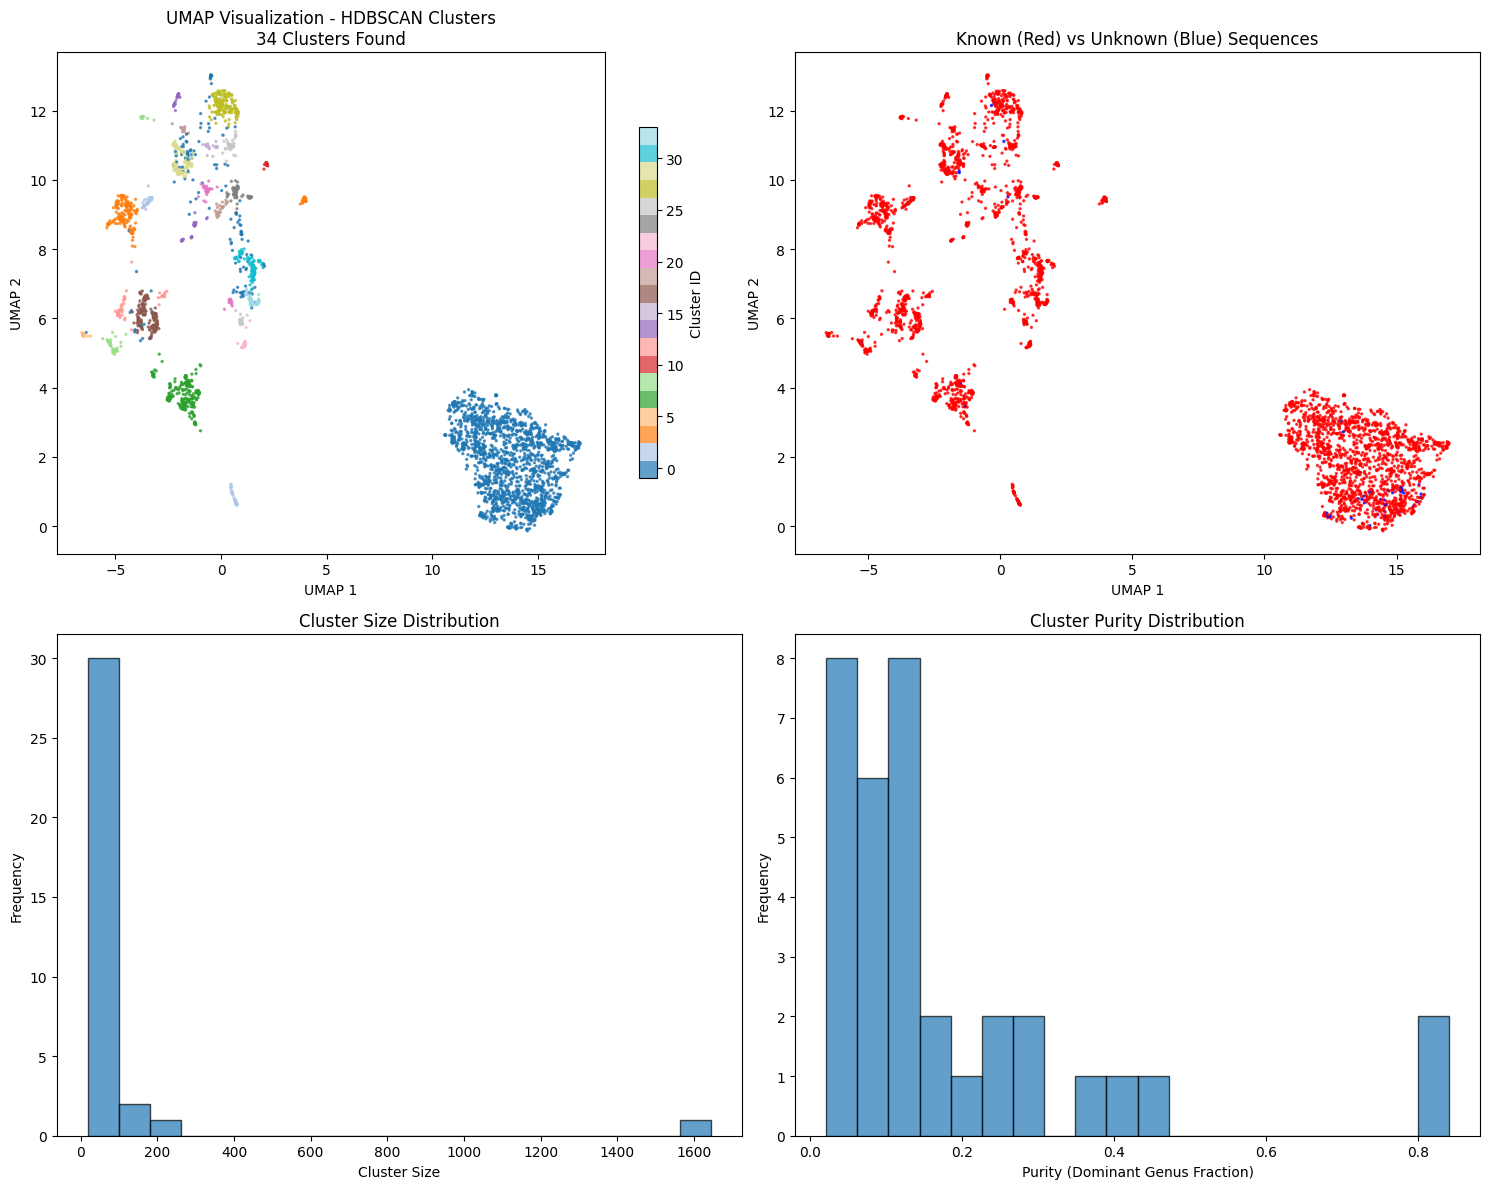

🎉 COMPREHENSIVE eDNA BIODIVERSITY ANALYSIS COMPLETE!

📊 DATASET SUMMARY:
   Total Sequences: 3,568
   Valid Sequences: 3,568
   Labeled Sequences: 3,509
   Label Coverage: 98.35%

📊 SUPERVISED LEARNING:
   Training Sequences: 1,040
   Known Genera: 176
   Test Accuracy: 0
   Test F1 Weighted: 0
   Test F1 Macro: 0

📊 UNSUPERVISED DISCOVERY:
   Total Clusters: 34
   Noise Sequences: 151
   Clustering Coverage: 95.77%
   Potential Novel Taxa: 0
   High Purity Clusters: 2

📊 BIODIVERSITY METRICS:
   Total Estimated Taxa: 176
   Known Taxa: 176
   Novel Taxa Candidates: 0
   Discovery Rate: 0.00%

🔬 KEY FINDINGS:
   ✅ Classified 176 known genera
   ✅ Discovered 0 potential novel taxa
   ✅ Weighted F1-score: 0.00%
   ✅ Clustered 95.8% of sequences


In [53]:
# ========================================
# CELL 13: Visualization and Final Assessment (PATCHED)
# ========================================

import matplotlib.pyplot as plt

# --- Create comprehensive visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: UMAP visualization colored by clusters
scatter1 = axes[0,0].scatter(
    umap_viz[:, 0], umap_viz[:, 1],
    c=cluster_labels, cmap='tab20', s=2, alpha=0.7
)
axes[0,0].set_title(f'UMAP Visualization - HDBSCAN Clusters\n{n_clusters} Clusters Found')
axes[0,0].set_xlabel('UMAP 1')
axes[0,0].set_ylabel('UMAP 2')
fig.colorbar(scatter1, ax=axes[0,0], label="Cluster ID", shrink=0.7)

# Plot 2: Known vs Unknown sequences
labeled_mask = np.array([seq_id in taxonomic_labels for seq_id in seq_ids])
colors = np.where(labeled_mask, "red", "blue")
axes[0,1].scatter(umap_viz[:, 0], umap_viz[:, 1], c=colors, s=2, alpha=0.7)
axes[0,1].set_title('Known (Red) vs Unknown (Blue) Sequences')
axes[0,1].set_xlabel('UMAP 1')
axes[0,1].set_ylabel('UMAP 2')

# Plot 3: Cluster size distribution
cluster_sizes = [info["size"] for info in cluster_analysis.values()]
axes[1,0].hist(cluster_sizes, bins=20, alpha=0.7, edgecolor="black")
axes[1,0].set_title("Cluster Size Distribution")
axes[1,0].set_xlabel("Cluster Size")
axes[1,0].set_ylabel("Frequency")

# Plot 4: Cluster purity distribution
purities = [info["purity"] for info in cluster_analysis.values()]
axes[1,1].hist(purities, bins=20, alpha=0.7, edgecolor="black")
axes[1,1].set_title("Cluster Purity Distribution")
axes[1,1].set_xlabel("Purity (Dominant Genus Fraction)")
axes[1,1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("biodiversity_analysis.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Final comprehensive assessment ---
def generate_final_assessment():
    """Generate comprehensive biodiversity assessment."""

    supervised_genera = len(genus_encoder.classes_)
    potential_novel_taxa = len(novel_candidates)
    high_purity_clusters = len([c for c in cluster_analysis.values() if c["purity"] > 0.8])

    # Count labeled sequences properly (intersection)
    labeled_sequences = sum(1 for sid in seq_ids if sid in taxonomic_labels)

    assessment = {
        "dataset_summary": {
            "total_sequences": len(sequences),
            "valid_sequences": len(sequences),
            "labeled_sequences": labeled_sequences,
            "label_coverage": labeled_sequences / len(sequences) * 100
        },
        "supervised_learning": {
            "training_sequences": len(train_seqs),
            "known_genera": supervised_genera,
            "test_accuracy": test_results.get("eval_accuracy", 0),
            "test_f1_weighted": test_results.get("eval_f1_weighted", 0),
            "test_f1_macro": test_results.get("eval_f1_macro", 0)
        },
        "unsupervised_discovery": {
            "total_clusters": n_clusters,
            "noise_sequences": n_noise,
            "clustering_coverage": (len(cluster_labels) - n_noise) / len(cluster_labels) * 100,
            "potential_novel_taxa": potential_novel_taxa,
            "high_purity_clusters": high_purity_clusters
        },
        "biodiversity_metrics": {
            "total_estimated_taxa": supervised_genera + potential_novel_taxa,
            "known_taxa": supervised_genera,
            "novel_taxa_candidates": potential_novel_taxa,
            "discovery_rate": (
                potential_novel_taxa / (supervised_genera + potential_novel_taxa) * 100
                if (supervised_genera + potential_novel_taxa) > 0 else 0
            )
        }
    }
    return assessment


# --- Generate final assessment ---
final_assessment = generate_final_assessment()

print("=" * 80)
print("🎉 COMPREHENSIVE eDNA BIODIVERSITY ANALYSIS COMPLETE!")
print("=" * 80)

for category, metrics in final_assessment.items():
    print(f"\n📊 {category.upper().replace('_', ' ')}:")
    for key, value in metrics.items():
        if isinstance(value, float):
            if "rate" in key or "coverage" in key or "accuracy" in key or "f1" in key:
                print(f"   {key.replace('_', ' ').title()}: {value:.2f}%")
            else:
                print(f"   {key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"   {key.replace('_', ' ').title()}: {value:,}")

print(f"\n🔬 KEY FINDINGS:")
print(f"   ✅ Classified {final_assessment['supervised_learning']['known_genera']} known genera")
print(f"   ✅ Discovered {final_assessment['unsupervised_discovery']['potential_novel_taxa']} potential novel taxa")
print(f"   ✅ Weighted F1-score: {final_assessment['supervised_learning']['test_f1_weighted']:.2%}")
print(f"   ✅ Clustered {final_assessment['unsupervised_discovery']['clustering_coverage']:.1f}% of sequences")
print("=" * 80)
